**THIS Notebook does a simple linear regression on data from Libraries.io** 
The getting the data part is very much hacked together but it is placeholder data anyway,
The regression stuff should be quite solid.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pickle
import time
from sklearn.datasets import load_boston
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score




pd.set_option('display.max_columns', 500)

In [10]:
N_SAMPLES = 500000
VERBOSE = True
ALPHA = [0.0001,0.001,0.01,0.1, 1]
P_CUTOFF = 0.01
TESTING = True
PATH ="/home/rick/UH-Spring-2019/Project/codescoop-models/Libraries_io_data/repositories-1.2.0-2018-03-12.csv"

In [11]:
#Functions for factorizing and getting dummies
def gnumeric_func (data, columns):
    data[columns] = data[columns].apply(lambda x: pd.factorize(x)[0])
    return data

def getDummies (data, feature):
    dummies = pd.get_dummies(data[feature])
    data = pd.concat([data, dummies], axis=1)
    data = data.drop([feature],axis=1)
    return data

def convertDateTime(data):
    data[['Created Timestamp', 'Updated Timestamp']] = data[['Created Timestamp', 'Updated Timestamp']].apply(pd.to_datetime)
    data['fulltime'] = (max(data['Updated Timestamp']) - data['Created Timestamp'])
    data['fulltime'] = data['fulltime'].apply(lambda x: x.days)
    return data

def getDatax(data):
    droplist = ['fulltime','SourceRank','Description', 'Name with Owner', 'Created Timestamp', "Updated Timestamp", 'Last pushed Timestamp', 'Homepage URL', 'Mirror URL', 'UUID', 'Last Synced Timestamp','Fork Source Name with Owner', 'Changelog filename', 'Contributing guidelines filename', 'License filename','Code of Conduct filename', 'Security Threat Model filename', 'Security Audit filename', 'SCM type', 'Logo URL', 'Keywords', 'Stars Count' ]
    factorizelist = ['Default branch', 'Display Name', 'Pull requests enabled'] 
    truefalselist = ['Fork', 'Issues enabled', 'Wiki enabled', 'Pages enabled']
    dummieslist = ['Language', 'License', 'Status','Host Type']

    datax = data.drop(droplist, axis=1)
    datax = datax.drop(['Readme filename'], axis=1) #idk why I need to do it separately, needs cleaning

    datax = gnumeric_func(datax, factorizelist)
    datax[truefalselist] = datax[truefalselist] * 1

    for item in dummieslist:
        datax = getDummies(datax,item)
        
    return datax

def runOLS(featureList, target, printoutput = True):

    dataxStats = datax[featureList]
    statsmodel = sm.OLS(target, dataxStats.astype(float)).fit()
    if printoutput:
        print(statsmodel.summary())
    return statsmodel



In [12]:
#getting the explanatory variables, and changing categorial values to dummies
data = pd.read_csv(PATH, usecols=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38], 
                   nrows = N_SAMPLES)

data = convertDateTime(data)

datay = data['Stars Count']/data['fulltime']

datax = getDatax(data)

datax.head()

/home/rick/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (16,38) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Fork,Size,Issues enabled,Wiki enabled,Pages enabled,Forks Count,Open Issues Count,Default branch,Watchers Count,Contributors Count,Display Name,Pull requests enabled,1C Enterprise,ABAP,AGS Script,AMPL,ANTLR,API Blueprint,ASP,ActionScript,Ada,Agda,Alloy,ApacheConf,Apex,AppleScript,Arc,Arduino,AspectJ,Assembly,AutoHotkey,AutoIt,Awk,Batchfile,Bison,BitBake,Boo,Brainfuck,Brightscript,C,C#,C++,CMake,COBOL,CSS,CartoCSS,Ceylon,Cirru,Clarion,Clean,Clojure,CoffeeScript,ColdFusion,Common Lisp,Component Pascal,Coq,Crystal,Cucumber,Cuda,D,DIGITAL Command Language,Dart,Diff,Dogescript,Dylan,Eagle,Eiffel,Elixir,Elm,Emacs Lisp,Erlang,F#,FLUX,FORTRAN,Fancy,Forth,Fortran,FreeMarker,Frege,GAP,GCC Machine Description,GDB,GLSL,Game Maker Language,Genshi,Gettext Catalog,Gherkin,Gnuplot,Go,Gosu,Groff,Groovy,HCL,HTML,Hack,Handlebars,Haskell,Haxe,Hy,IDL,Idris,Inno Setup,Io,Isabelle,JSONiq,Jasmin,Java,JavaScript,Julia,Jupyter Notebook,KiCad,Kit,Kotlin,LLVM,LSL,Lasso,Liquid,LiveScript,Logos,LookML,Lua,M,M4,Makefile,Mask,Mathematica,Matlab,Max,Mercury,Mirah,MoonScript,NCL,NSIS,Nemerle,NetLinx,NetLogo,NewLisp,Nginx,Nim,Nimrod,Nix,OCaml,Objective-C,Objective-C++,Objective-J,OpenEdge ABL,OpenSCAD,Oxygene,PHP,PLSQL,PLpgSQL,POV-Ray SDL,Pan,Pascal,Perl,Perl 6,Perl6,PigLatin,PogoScript,PostScript,PowerShell,Processing,Prolog,Propeller Spin,Protocol Buffer,Puppet,Pure Data,PureScript,Python,QML,R,RAML,REALbasic,Racket,Ragel,Ragel in Ruby Host,Rebol,RenderScript,RobotFramework,Roff,Ruby,Rust,SMT,SQL,SQLPL,SaltStack,Scala,Scheme,Scilab,Shell,Shen,Slash,Smali,Smalltalk,Smarty,SourcePawn,Squirrel,Standard ML,Stata,SuperCollider,Swift,Tcl,TeX,Thrift,TypeScript,VCL,VHDL,Vala,Verilog,Vim script,VimL,Visual Basic,Vue,Web Ontology Language,WebAssembly,X10,XML,XProc,XQuery,XS,XSLT,Xtend,Yacc,Zephir,eC,nesC,wisp,AFL-3.0,AGPL-3.0,Apache-2.0,Artistic-2.0,BSD-2-Clause,BSD-3-Clause,BSD-3-Clause-Clear,BSL-1.0,CC-BY-4.0,CC-BY-NC-ND-3.0,CC-BY-SA-3.0,CC-BY-SA-4.0,CC0-1.0,ECL-2.0,EPL-1.0,EUPL-1.1,GPL-2.0,GPL-3.0,GPL-3.0+,ISC,LGPL-2.0,LGPL-2.1,LGPL-2.1+,LGPL-3.0,LGPL-3.0+,MIT,MPL-2.0,MS-PL,MS-RL,OFL-1.1,OSL-3.0,Other,Unlicense,Vim,W3C,WTFPL,Zlib,agpl-3.0,apache-2.0,bsd-2-clause,bsd-3-clause,bsd-3-clause-clear,gpl-2.0,gpl-3.0,isc,lgpl-2.1,lgpl-3.0,mit,mpl-2.0,other,unlicense,wtfpl,Active,Deprecated,Help Wanted,Unmaintained,GitHub,GitLab
1,0,512,1,1,1,0,1,0,2,1,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,924,1,1,0,782,85,0,61,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,1,472,0,1,0,0,0,0,1,5,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [13]:
data.head()

,Host Type,Name with Owner,Description,Fork,Created Timestamp,Updated Timestamp,Last pushed Timestamp,Homepage URL,Size,Stars Count,Language,Issues enabled,Wiki enabled,Pages enabled,Forks Count,Mirror URL,Open Issues Count,Default branch,Watchers Count,UUID,Fork Source Name with Owner,License,Contributors Count,Readme filename,Changelog filename,Contributing guidelines filename,License filename,Code of Conduct filename,Security Threat Model filename,Security Audit filename,Status,Last Synced Timestamp,SourceRank,Display Name,SCM type,Pull requests enabled,Logo URL,Keywords,fulltime
1,GitHub,brianmhunt/knockout-modal,Opinionated modals with Knockout.js,False,2014-09-15 01:21:34,2016-12-28 16:33:17,2016-12-18 18:31:32 UTC,http://brianmhunt.github.io/knockout-modal/,512,7,JavaScript,True,True,True,0,NaN,1,master,2,24038237,NaN,MIT,1,README.md,NaN,NaN,LICENSE,NaN,NaN,NaN,NaN,2016-05-27 15:42:48 UTC,5,GitHub,NaN,NaN,NaN,NaN,1274
2,GitHub,SteveSanderson/knockout.mapping,Object mapping plugin for KnockoutJS,False,2010-11-01 09:27:43,2018-02-11 10:04:55,2017-06-21 22:54:45 UTC,NaN,924,543,JavaScript,True,True,False,782,NaN,85,master,61,1041356,NaN,MIT,21,README.md,NaN,NaN,LICENSE,NaN,NaN,NaN,NaN,2016-05-27 15:21:05 UTC,8,GitHub,NaN,git,NaN,NaN,2688
3,GitHub,azman-co/knockout-model,A set of useful model and collection features ...,True,2014-09-13 03:14:07,2017-03-18 22:40:02,2015-01-14 02:01:03 UTC,NaN,472,1,JavaScript,False,True,False,0,NaN,0,master,1,23984550,devco/knockup,NaN,5,README.md,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-05-27 16:07:08 UTC,2,GitHub,NaN,NaN,NaN,NaN,1276
4,GitHub,zonuexe/aozora-ruby-parser.js,Aozora-bunko ruby parser,False,2014-12-27 21:02:09,2016-12-28 16:45:20,2015-01-07 18:04:42 UTC,http://zonuexe.github.io/aozora-ruby-parser.js/,536,3,JavaScript,True,True,True,1,NaN,2,master,1,28546273,NaN,NaN,1,README.md,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-05-27 17:22:36 UTC,3,GitHub,NaN,NaN,NaN,NaN,1170
5,GitHub,immense/knockout-pickatime,Pickadate timepicker binding for Knockout.js,False,2014-12-04 21:13:48,2017-03-18 22:40:04,2014-12-11 16:12:08 UTC,http://rawgit.com/immense/knockout-pickatime/m...,192,1,CoffeeScript,True,True,False,0,NaN,0,master,2,27560378,NaN,MIT,1,README.md,NaN,NaN,LICENSE,NaN,NaN,NaN,NaN,2016-05-27 18:52:59 UTC,4,GitHub,NaN,NaN,NaN,NaN,1193


alpha =  0.0001
Training score: 0.6227969900768334
Test score:  0.6330980837525522
Number of features used:  29
 
alpha =  0.001
Training score: 0.6208364151317272
Test score:  0.631740705839881
Number of features used:  15
 
alpha =  0.01
Training score: 0.6187294000010886
Test score:  0.6303460985372802
Number of features used:  6
 
alpha =  0.1
Training score: 0.6185123140631535
Test score:  0.6314334574768719
Number of features used:  6
 
alpha =  1
Training score: 0.6049811515601949
Test score:  0.6218735553621983
Number of features used:  4
 
Optimal alpha =  0.0001


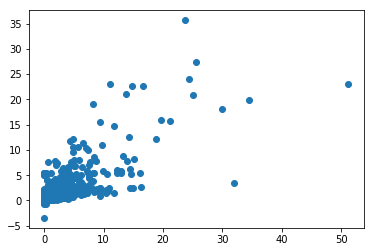

Mean squared error:  0.06283407841493299
Model R² score:  0.6330980837525522


In [14]:
# This code demonstrates how to use lasso regression for choosing optimal variables
# for a linear model.

# x should be a dataframe containing the explanatory variables (forks, language, etc)
x = datax

# y should be a vector containing the target variable (number of stars)
y = list(datay)

# split the data in to train and test part
X_train, X_test, y_train, y_test = train_test_split(x, y)


## trying different alphas and choosing the optimal model

# if fitting of the model is really slow, you can drop last values of alpha to make it faster
alphas = ALPHA
n = len(alphas)
test_scores = np.zeros(n)

for i in range(0,n):
    a = alphas[i]
    lasso = Lasso(alpha = a, max_iter = 10e5)
    lasso.fit(X_train, y_train)
    train_score=lasso.score(X_train,y_train)
    test_score=lasso.score(X_test,y_test)
    test_scores[i] = test_score
    coeff_used = np.sum(lasso.coef_!=0)
    
    if VERBOSE:
        print("alpha = ", a)
        print("Training score:", train_score)
        print("Test score: ", test_score)
        print("Number of features used: ", coeff_used)
        print(" ")

# pick the alpha value with best score
best_alpha = alphas[np.argmax(test_scores)]
lasso = Lasso(alpha = best_alpha, max_iter = 10e5)
lasso.fit(X_train, y_train)

# create a dataframe with the coefficents of the features,
# then create a list of the features selected to use in OLS
df_coef = pd.DataFrame({'Features':x.columns,'coeff': lasso.coef_})
df_coef = df_coef.sort_values(by = ['coeff'])
df_coef = df_coef[df_coef.coeff != -0.0]
featureList = list(df_coef.Features)
    
# model summary
predicted = lasso.predict(X_test)
expected = y_test
# expected vs predicted values
if VERBOSE:
    print("Optimal alpha = ", best_alpha)
    plt.scatter(expected, predicted)
    plt.show()
    print("Mean squared error: ", mean_squared_error(expected, predicted))
    print("Model R² score: ", r2_score(expected, predicted))

In [15]:
pvals = runOLS(featureList=featureList, target=y, printoutput=False).pvalues

keylist_second = list(dict(pvals[pvals < P_CUTOFF]).keys())


final_model = runOLS(keylist_second, y)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                 3.687e+04
Date:                Mon, 01 Apr 2019   Prob (F-statistic):               0.00
Time:                        11:39:33   Log-Likelihood:                 6217.4
No. Observations:              500000   AIC:                        -1.239e+04
Df Residuals:                  499977   BIC:                        -1.213e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Java                     -0.05

In [ ]:
# Save model to pickle
if TESTING == False:
    pickle.dump(final_model, open('pickle_model', 'wb'))


In [ ]:
pd.DataFrame(final_model.params).index.values